# Assignment 3: Tracking station vs. Tracking network: quality assessment
In this assignment, you will use simulated observations to investigate how the different settings and variables that can affect the quality of the estimation. To do so, you will modify a number of settings in the above code:
- the total propagation time, and the duration of the tracking arcs
- the quality of the simulated Doppler measurements
- the number and location of the simulated ground stations
- the accuracy of the initial guess for the spacecraft's state **prior to the estimation**
- the parameters that are included in the estimation

The code automatically provides you with a number of printed outputs and plots. It prints the following:
- true errors = deviations between the estimated parameters and their *true* values (i.e. their values in our model, used both to propagate the spacecraft's dynamics and simulate the Doppler data). 
- formal errors = statistical estimates of the solution's accuracy, for each estimated parameters. 

The pre-coded figures show, in order of appearance: 
1. The ground station locations
2. The simulated Doppler measurements as a function of time.
3. The ratio between the true and formal errors, for each estimated parameter.
4. The initial and final observation residuals (iterations 0 and 10, respectively), as a function of time, superimposed with the $1\sigma$ and $3\sigma$ values describing the simulated Doppler noise.
5. The histogram of the final observation residuals, again superimposed with the noise $1\sigma$ and $3\sigma$ values.
6. The correlation matrix between all estimated parameters.

Tudat will also print the list of all estimated parameters, which will allow you to trace back which index corresponds to which parameter, both in the figures and in the printed error vectors.

You are of course free to provide other plots and/or results to complete this assignment if you think that they bring additional insights or support your argumentation more efficiently. 

Throughout this assignment, you can use the following **nominal** settings, unless specified otherwise. 
 - total propagation time = 1 day
 - tracking arc duration = 1 day 
 - Doppler noise = 1 m/s 
 - ground station = only DopTrack (Delft)
 - perturbation of the initial guess for the spacecraft's state = based on the next TLE update (see comment in the code for more detail)
 - estimated parameters:
	 - spacecraft's initial state (per arc)
	 - Earth's gravitational parameter
	 - spacecraft's drag coefficient
You are free to modify these settings to either improve your solution, or generate additional results to support your argumentation. If you do so, please indicate it in your report with a short justification for your choice.


**TIP:** if an estimation fails during the assignment, you might still retrieve the formal uncertainties and correlations by setting the number of iterations to 1. Be aware that the true errors and observation residuals will **not be converged** in this case, but they will simply be returned after only one iteration. The formal errors and correlations, however, might provide some insights into why the estimation failed.  

In [1]:
# Load required standard modules
import numpy as np
from matplotlib import pyplot as plt

# Load tudatpy modules
from tudatpy import constants
from tudatpy.interface import spice
from tudatpy import numerical_simulation
from tudatpy.numerical_simulation import environment
from tudatpy.numerical_simulation import environment_setup
from tudatpy.numerical_simulation import propagation_setup
from tudatpy.numerical_simulation import estimation, estimation_setup
from tudatpy.numerical_simulation.estimation_setup import observation
from tudatpy.astro.time_conversion import DateTime
from tudatpy.astro import element_conversion

# Import doptrack-estimate functions
from propagation_functions.environment import *
from propagation_functions.propagation import *
from estimation_functions.estimation import *
from utility_functions.tle import *

import cartopy.crs as ccrs

# Load spice kernels
spice.load_standard_kernels()

# Simulating Delfi-C3

Lets take a typical satellite orbit and assess on theory how well we can estimate it orbit.

In [2]:
# Define initial TLE of your spacecraft
# You can modify the initial TLE used to initialise the orbit of your spacecraft (although not recommended for this assignment)
delfi_tle = environment.Tle("1 32789U 08021G   20090.88491347 +.00001016 +00000-0 +70797-4 0  9997",
                            "2 32789 097.4279 136.4027 0011143 218.6381 141.4051 15.07550601649972")

# Retrieve initial epoch from TLE
initial_epoch = delfi_tle.get_epoch()

# Orbit duration and number of arcs 

During this assignment, you will be asked to modify this propagation duration, for instance to test the effect of using a longer observational time on the quality of your estimation solution. Whenever modifying this value, think about whether you also want to modify the duration of the tracking arcs. The total propagation duration will automatically be divided into how many tracking arcs as necessary.

In [3]:
# Define the time over which you want to propagate your simulated spacecraft orbit
propagation_time = 1.0 * constants.JULIAN_DAY

# Compute final and mid-propagation epochs. The propagation will be initiated at mid_epoch, and performed both backwards (up to initial_epoch)
# and forwards (up to final_epoch).
final_epoch = initial_epoch + propagation_time
mid_epoch = (initial_epoch + final_epoch) / 2.0

# Define arc duration, and compute the corresponding start, middle, and end times of each arc
# In this assignment, you will be asked to modify this value. Be aware that more tracking arcs can result in an increased number of estimated
# parameters, if some of them are estimated in an arc-wise manner.
arc_duration = 1.0 * constants.JULIAN_DAY
arc_start_times, arc_mid_times, arc_end_times = get_arc_times_definition(initial_epoch, final_epoch, arc_duration)
nb_arcs = len(arc_mid_times)

In [4]:
# Define the properties of your simulated spacecraft, and the propagation environment
mass = 2.2
ref_area = (4 * 0.3 * 0.1 + 2 * 0.1 * 0.1) / 4  # Average projection area of a 3U CubeSat
drag_coef = 1.2
srp_coef = 1.2
bodies = define_environment(mass, ref_area, drag_coef, srp_coef, "spacecraft", multi_arc_ephemeris=True)

# Define accelerations exerted on your simulated spacecraft. For this assignment, you are not requested to modify this accelerations list.
# Warning: point_mass_gravity and spherical_harmonic_gravity accelerations should not be defined simultaneously for a single body
accelerations = dict(
    Sun={
        'point_mass_gravity': True,
        'solar_radiation_pressure': True
    },
    Moon={
        'point_mass_gravity': True
    },
    Earth={
        'point_mass_gravity': False,
        'spherical_harmonic_gravity': True,
        'drag': True
    },
    Venus={
        'point_mass_gravity': True
    },
    Mars={
        'point_mass_gravity': True
    },
    Jupiter={
        'point_mass_gravity': True
    }
)

# Retrieve the spacecraft's initial state at mid-epoch from the TLE ephemeris
delfi_ephemeris = environment.TleEphemeris("Earth", "J2000", delfi_tle, False)
initial_state = delfi_ephemeris.cartesian_state(mid_epoch)

# Because we might have to divide the propagation in several arcs, we need to define the spacecraft's **arc-wise** initial states.
# To use consistent arc-wise initial states (they still all belong to a single spacecraft orbit!), we propagate the spacecraft's orbit
# from its **global** initial state defined earlier over the entire propagation duration. From this **global** propagated orbit, we
# then retrieve the spacecraft's states at the mid-epoch of each arc, to be later used as initial condition for the **arc_wise** propagation.
global_orbit = propagate_initial_state(initial_state, initial_epoch, final_epoch, bodies, accelerations, "spacecraft", save_ephemeris=False)
arc_wise_initial_states = retrieve_arc_wise_states_from_orbit(global_orbit, arc_mid_times)

# Create mutli-arc propagation settings
multi_arc_propagation_settings = define_multi_arc_propagation_settings(
    arc_wise_initial_states, arc_start_times, arc_end_times, bodies, accelerations, "spacecraft")

# Groundstation coverage

In this assignment, you will be asked the number of "fake" stations you want to create below. Always make sure that the size of the stations' longitude and latitude vectors below matches the number of stations you want to create (the code is pre-defined for 2 "fake", which is what you will need in most of this assignment).

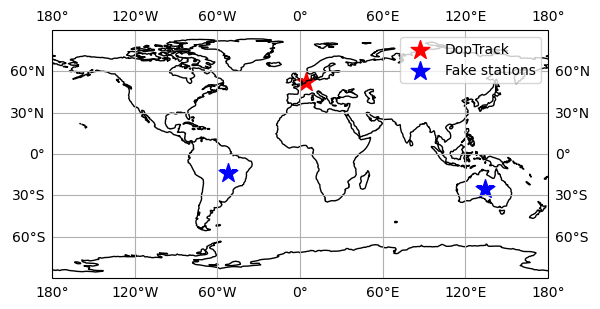

In [5]:
# Create the DopTrack ground station
define_doptrack_station(bodies)

# Create "fake" ground station(s) and specify their location(s)
nb_fake_stations = 2

# Pre-defined coordinates of "fake" ground stations close to DopTrack (located in Den Haag and Rotterdam, respectively)
# Comment/uncomment the following two lines depending on where you want your "fake" stations to be located
# stations_lat = [52.0705, 51.9244]
# stations_long = [4.3007, 4.4777]

# Pre-defined coordinates of "fake" ground stations far away from DopTrack (located in Australia and Braxil, respectively)
# Comment/uncomment the following two lines depending on where you want your "fake" stations to be located
stations_lat = [-25.0, -14.0]
stations_long = [134.0, -52.0]

# Create all stations (DopTrack and as many "fake" stations as defined above)
stations_names = create_ground_stations(bodies, nb_fake_stations, stations_long, stations_lat)

# Plot ground station locations
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.scatter(4.3571, 52.0116, color='red', marker='*', s=200, label='DopTrack')
if nb_fake_stations>0:
    ax.scatter(stations_long,stations_lat, color='blue', marker='*', s=200, label='Fake stations')
ax.gridlines(draw_labels=True)
ax.set_xlim(-180.0, 180.0)
ax.set_ylim(-90.0, 90.0)
ax.legend()
plt.show()

In [6]:
# Define all uplink link ends for which one-way Doppler observables will be simulated
link_definitions = create_link_ends_definitions(nb_fake_stations)

# Create observation settings for each link/observable
observation_settings_list = []
for link in link_definitions:
    observation_settings_list.append(observation.one_way_doppler_instantaneous(link))

# Define times at which Doppler measurements should be simulated (every 10.0 seconds)
observation_times = np.arange(initial_epoch, final_epoch, 10.0)

# Define observation simulation settings
observation_simulation_settings = []
for i in range(nb_fake_stations + 1):
    observation_simulation_settings.append(observation.tabulated_simulation_settings(
        observation.one_way_instantaneous_doppler_type, link_definitions[i], observation_times))

# Measurement precision

From the previous assignments you observed the precission of the Doppler data for different satellites. Here, with the parameter noise_level (default 1 m/s), you  are able to simulate any Gaussian uncertaonty on the simulated Doppler data and assess its effect on the orbit determination.

In [7]:
# Add Gaussian noise to simulated Doppler observations.
# In this assignment, you will be asked to modify this noise level value.
noise_level = 0.1  # in m/s
observation.add_gaussian_noise_to_observable(observation_simulation_settings, noise_level,
                                             observation.one_way_instantaneous_doppler_type)

# Create observation viability settings
# For each station, we only simulated Doppler data when the spacecraft is visible from the station and above an elevation mask of 15 degrees
for i in range(nb_fake_stations + 1):
    viability_setting = observation.elevation_angle_viability(["Earth", stations_names[i]], np.deg2rad(15))

    observation.add_viability_check_to_observable_for_link_ends(
        [observation_simulation_settings[i]], [viability_setting], observation.one_way_instantaneous_doppler_type, link_definitions[i])

# Parameter Estimation

From the SOD lectures you learned that orbit estimation is not only useful to determine the positional state of the spacecraft, but also to estimate values for certain environmental parameters, like atmospheric drag or gravitational perturbations.

In [8]:
# Define parameters to estimate
# In this assignment, you will be asked to modify this list, to include the estimation of Earth's C20 and C22 gravity field coefficients
parameters_list = dict(
    initial_state={
        'estimate': True
    },
    drag_coefficient={
        'estimate': True,
        'type': 'global'
    },
    gravitational_parameter={
        'estimate': True,
        'type': 'global'  # can only be global
    },
    C20={
        'estimate': False,
        'type': 'global'  # can only be global
    },
    C22={
        'estimate': False,
        'type': 'global'  # can only be global
    }
)
parameters_to_estimate = define_parameters(parameters_list, bodies, multi_arc_propagation_settings, "spacecraft",
                                           arc_start_times, arc_mid_times)

# Print estimated parameter names and corresponding indices
estimation_setup.print_parameter_names(parameters_to_estimate)
nb_parameters = parameters_to_estimate.parameter_set_size

# Save the true parameter values to later analyse the estimation errors
truth_parameters = parameters_to_estimate.parameter_vector

# Create estimator object
estimator = numerical_simulation.Estimator(
    bodies, parameters_to_estimate, observation_settings_list, multi_arc_propagation_settings)

Parameter start index, Parameter definition
0, arc-wise translational state of (spacecraft).
6, constant drag coefficient of (spacecraft).
7, gravitational parameter of (Earth).



# Simulated Doppler measurements

Now that you have set your orbit scenario and groundstation architecture, you can simulate the Doppler data that you would acquire in real-life. This data is similar to the DopTrack data from Assignment 1 and 2. 

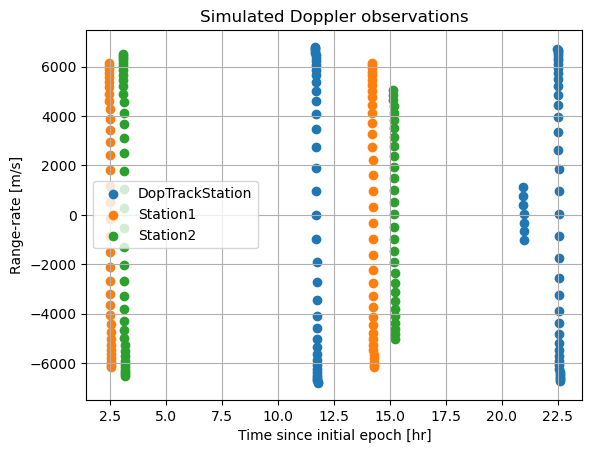

In [9]:
# Simulate Doppler measurements
simulated_observations = estimation.simulate_observations(
    observation_simulation_settings, estimator.observation_simulators, bodies)

# Retrieve simulated observations, and sort per ground station
sorted_obs_collection = simulated_observations.sorted_observation_sets
observation_times = np.array(simulated_observations.concatenated_times)
observations_list = np.array(simulated_observations.concatenated_observations)

# Plot simulated Doppler observations for each station, as a function of time.
plt.figure()
plt.title("Simulated Doppler observations")
for obs in sorted_obs_collection.values():
    for i in range(len(obs)):
        plt.scatter((np.array(obs[i][0].observation_times) - initial_epoch) / 3600.0,
                    obs[i][0].concatenated_observations, label=stations_names[i])
plt.grid()
plt.xlabel("Time since initial epoch [hr]")
plt.ylabel("Range-rate [m/s]")
plt.legend()
plt.show()

# Pertubation of initial state

Set the boolean "use_next_tle_as_perturbation" and "use_manual_perturbation" to True/False depending on which initial state perturbation strategy you want to apply. This will be modified throughout the assignment. There are two perturbation strategies:

- Wrong TLE selection as initial state (not the closest TLE available)
- Random gaussian uncertainty on position and velocity of the initial state


In [10]:
# Perturb the initial state estimate from the truth
perturbed_parameters = truth_parameters.copy()
use_next_tle_as_perturbation = True
use_manual_perturbation = False

# Use next TLE update to derive realistic initial state perturbation
if use_next_tle_as_perturbation:
    # Define next TLE update of your spacecraft
    # This corresponds to the TLE updated one day after the initial TLE provided above. The difference between the two provides
    # an estimate of the quality of our knowledge of this spacecraft's orbit.
    # This difference between the TLE orbits from one day to the next will be used later, in the simulated estimation, to derive
    # realistic errors for the initial guess of the spacecraft's state.
    next_delfi_tle = environment.Tle("1 32789U 08021G   20092.14603172 +.00001512 +00000-0 +10336-3 0  9992",
                                     "2 32789 097.4277 137.6209 0011263 214.0075 146.0432 15.07555919650162")
    next_delfi_ephemeris = environment.TleEphemeris("Earth", "J2000", next_delfi_tle, False)
    perturbed_arc_wise_initial_states = []
    for time in arc_mid_times:
        perturbed_arc_wise_initial_states.append(next_delfi_ephemeris.cartesian_state(time))

    for i in range(nb_arcs):
        perturbed_parameters[i * 6:(i + 1) * 6] = perturbed_arc_wise_initial_states[i]

# Perturb the initial state manually
if use_manual_perturbation:
    manual_position_perturbation = 1000.0  # in m
    manual_velocity_perturbation = 1.0  # in m/s
    manual_state_perturbation = np.concatenate((manual_position_perturbation * np.ones(3),
                                               manual_velocity_perturbation * np.ones(3)))
    for i in range(nb_arcs):
        perturbed_parameters[i * 6:(i + 1) * 6] += manual_state_perturbation

# Reset the estimated parameters to their perturbed values
parameters_to_estimate.parameter_vector = perturbed_parameters
initial_parameters_perturbation = perturbed_parameters - truth_parameters

# Start Estimation

Start the estimation of the chosen scenario and retrieve the estimated parameters and their formal errors. Because this is a simulation, we can asses the true errors and see how well the formal errors describe the true errors.

In [11]:
# Create input settings for the estimation
nb_iterations = 10  # number of least-squares iteration to be performed (this can be modified if the estimation fails, see tip)
convergence_checker = estimation.estimation_convergence_checker(maximum_iterations=nb_iterations)
estimation_input = estimation.EstimationInput(simulated_observations, convergence_checker=convergence_checker)

# Define observation weights
weights_per_observable = {estimation_setup.observation.one_way_instantaneous_doppler_type: noise_level ** -2}
estimation_input.set_constant_weight_per_observable(weights_per_observable)

# Perform the estimation
estimation_input.define_estimation_settings(reintegrate_variational_equations=True)
estimation_output = estimator.perform_estimation(estimation_input)

# Retrieve formal errors and (final) true errors
formal_errors = estimation_output.formal_errors
true_errors = parameters_to_estimate.parameter_vector - truth_parameters

# Retrieve correlation matrix
correlations = estimation_output.correlations

# Compute true error and true-to-formal error ratio for each parameter, at each iteration
# each column corresponds to one LSQ iteration
parameters_history = estimation_output.parameter_history
true_errors_history = np.zeros(parameters_history.shape)
true_to_formal_errors_history = np.zeros(parameters_history.shape)
for i in range(parameters_history.shape[1]):
    true_errors_history[:, i] = np.abs(parameters_history[:, i] - truth_parameters)
    true_to_formal_errors_history[:, i] = np.divide(true_errors_history[:, i], formal_errors)

# Retrieve final residuals and residuals history
final_residuals = estimation_output.final_residuals
residual_history = estimation_output.residual_history

Calculating residuals and partials 223
Current residual: 1.22223
Parameter update     22.7314     -101.301     -37.6909   0.00698152    0.0192648     0.110503    0.0067177 -6.49038e+08
Calculating residuals and partials 223
Current residual: 0.091475
Parameter update -0.0134161   0.0740471 -0.00653105 2.84071e-05 2.36197e-05 6.18896e-05 5.40601e-05 -1.0307e+07
Calculating residuals and partials 223
Current residual: 0.0914746
Parameter update-1.03685e-05  5.26489e-07  -1.0089e-06 -6.17154e-09 -1.17969e-09 -4.05509e-09 -4.51414e-07     -254.136
Calculating residuals and partials 223
Current residual: 0.0914746
Parameter update-9.00175e-06 -5.72184e-07 -8.22521e-06  -1.9795e-08 -5.77233e-09 -1.89951e-10 -1.91722e-07     -84.8967
Calculating residuals and partials 223
Current residual: 0.0914746
Parameter update 3.60337e-06 -1.80082e-06  1.75152e-06  6.63409e-09  1.47786e-09  2.03483e-09  1.27555e-07      100.574
Calculating residuals and partials 223
Current residual: 0.0914746
Parameter

###############################################
PRINTING ESTIMATION OUTPUTS
estimated parameters [ 4.78936791e+06 -4.78336019e+06 -1.43464407e+06 -1.81796932e+03
  3.83913521e+02 -7.36354229e+03  1.20677187e+00  3.98599782e+14]
initial parameters perturbation [-3.49580888e+01  9.63476407e+01  3.84593435e+01 -1.07517485e-02
 -2.23442596e-02 -1.07090778e-01  0.00000000e+00  0.00000000e+00]
true_errors [-1.22401411e+01 -4.87900376e+00  7.61973645e-01 -3.74180937e-03
 -3.05585468e-03  3.47438053e-03  6.77186669e-03 -6.59345022e+08]
formal errors [5.85524883e+00 3.62813961e+00 2.83394548e+00 7.67657019e-03
 8.70495468e-03 4.76147896e-03 1.44466114e-02 6.44533359e+08]
nb data points 223
###############################################


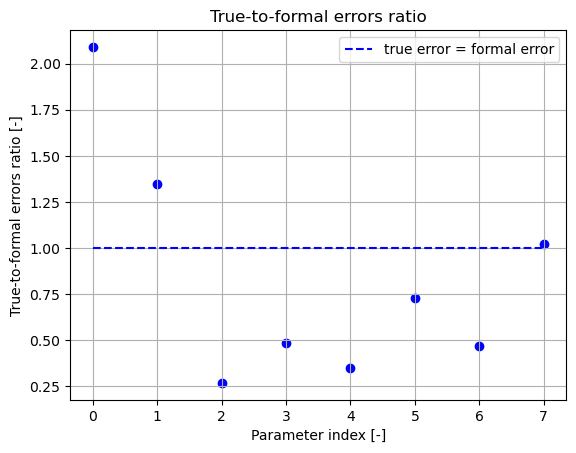

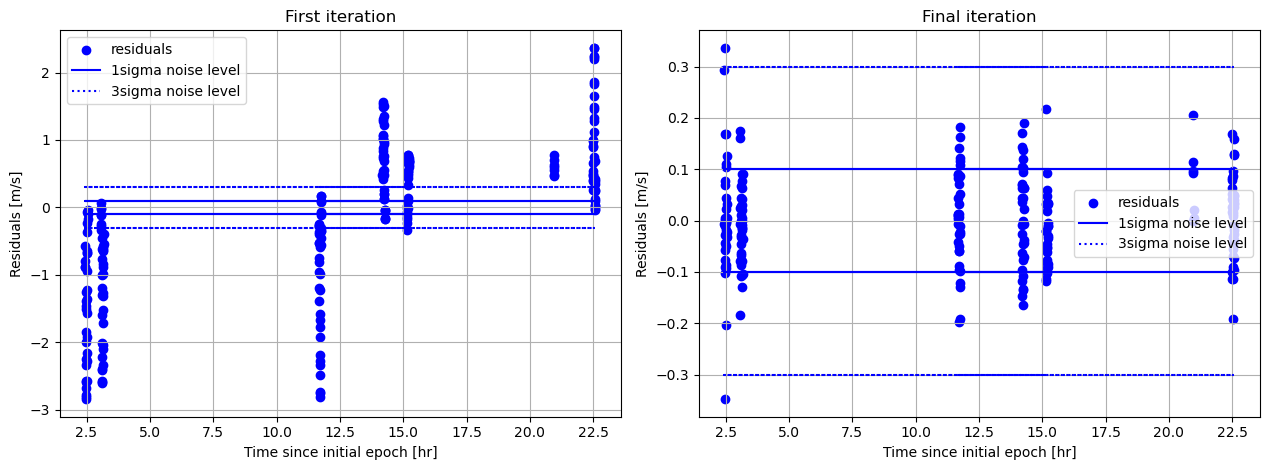

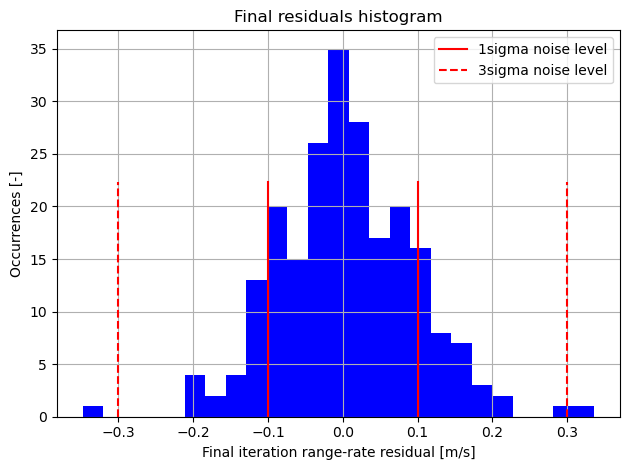

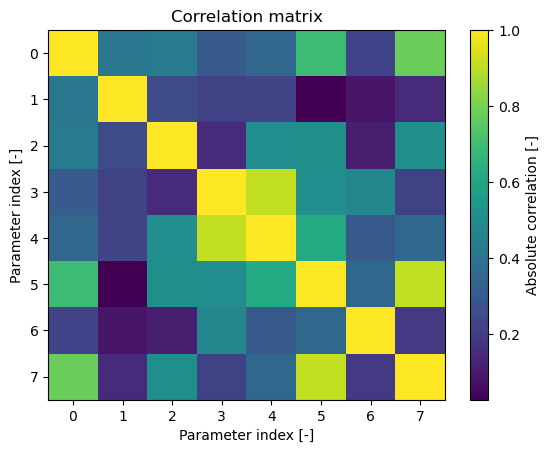

In [12]:
# Printing various estimation outputs
print('###############################################')
print('PRINTING ESTIMATION OUTPUTS')
print('estimated parameters', parameters_to_estimate.parameter_vector)
print('initial parameters perturbation', initial_parameters_perturbation)
print('true_errors', true_errors)
print('formal errors', formal_errors)
print('nb data points', len(observation_times))
print('###############################################')

# Pre-defined plots

# Plot true-to-formal errors ratio after the last least-squares iteration
plt.figure()
plt.title('True-to-formal errors ratio')
plt.scatter(np.arange(0, nb_parameters), true_to_formal_errors_history[:, -1], color='blue')
plt.plot(np.arange(0, nb_parameters), np.ones(nb_parameters), linestyle='dashed', color='blue',
         label='true error = formal error')
plt.xlabel('Parameter index [-]')
plt.ylabel('True-to-formal errors ratio [-]')
plt.grid()
plt.legend()
plt.show()

# Plot observation residuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.4 * 2, 4.8))

# First iteration residuals
ax1.scatter((np.array(observation_times) - initial_epoch) / 3600.0, residual_history[:, 0], color='blue',
            label='residuals')
ax1.plot((np.array(observation_times) - initial_epoch) / 3600.0, noise_level * np.ones(len(observation_times)),
         color='blue', label='1sigma noise level')
ax1.plot((np.array(observation_times) - initial_epoch) / 3600.0, -noise_level * np.ones(len(observation_times)),
         color='blue')
ax1.plot((np.array(observation_times) - initial_epoch) / 3600.0, 3 * noise_level * np.ones(len(observation_times)),
         color='blue', linestyle='dotted', label='3sigma noise level')
ax1.plot((np.array(observation_times) - initial_epoch) / 3600.0, -3 * noise_level * np.ones(len(observation_times)),
         color='blue', linestyle='dotted')
ax1.set_ylabel('Residuals [m/s]')
ax1.set_xlabel('Time since initial epoch [hr]')
ax1.set_title('First iteration')
ax1.grid()
ax1.legend()

# Final iteration residuals
ax2.scatter((np.array(observation_times) - initial_epoch) / 3600.0, residual_history[:, -1], color='blue',
            label='residuals')
ax2.plot((np.array(observation_times) - initial_epoch) / 3600.0, noise_level * np.ones(len(observation_times)),
         color='blue', label='1sigma noise level')
ax2.plot((np.array(observation_times) - initial_epoch) / 3600.0, -noise_level * np.ones(len(observation_times)),
         color='blue')
ax2.plot((np.array(observation_times) - initial_epoch) / 3600.0, 3 * noise_level * np.ones(len(observation_times)),
         color='blue', linestyle='dotted', label='3sigma noise level')
ax2.plot((np.array(observation_times) - initial_epoch) / 3600.0, -3 * noise_level * np.ones(len(observation_times)),
         color='blue', linestyle='dotted')
ax2.set_ylabel('Residuals [m/s]')
ax2.set_xlabel('Time since initial epoch [hr]')
ax2.set_title('Final iteration')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

# Plot final residuals histogram
plt.figure()
plt.hist(final_residuals, 25, color='blue')
plt.plot(-1.0 * noise_level * np.ones(2), [0, len(observation_times) / 10.0], color='red', linestyle='solid',
         label='1sigma noise level')
plt.plot(1.0 * noise_level * np.ones(2), [0, len(observation_times) / 10.0], color='red', linestyle='solid')
plt.plot(-3.0 * noise_level * np.ones(2), [0, len(observation_times) / 10.0], color='red', linestyle='dashed',
         label='3sigma noise level')
plt.plot(3.0 * noise_level * np.ones(2), [0, len(observation_times) / 10.0], color='red', linestyle='dashed')
plt.xlabel('Final iteration range-rate residual [m/s]')
plt.ylabel('Occurrences [-]')
plt.title('Final residuals histogram')
plt.tight_layout()
plt.grid()
plt.legend()
plt.show()

# Plot correlations matrix
plt.figure()
plt.imshow(np.abs(correlations), aspect='auto', interpolation='none')
plt.colorbar(label='Absolute correlation [-]')
plt.title('Correlation matrix')
plt.xlabel('Parameter index [-]')
plt.ylabel('Parameter index [-]')
plt.show()

# Reporting

In your report, you will take the following steps, and answer the corresponding questions. For each of them, feel free to provide any quantitative result or figure that you will judge necessary, besides for the ones explicitly required. Keep your answers short and concise, but do discuss, and not only describe, every figure that you choose to include.  

**Single-station case**

1. Run the code with the **nominal** settings, and provide the following:
	- formal errors values
	- plot showing the true-to-formal error ratio
	- correlations
	Comment on the realism of the formal uncertainties, and on the obtained correlations.

	Manually increase the perturbation of the initial guess for the spacecraft's state by 1 km and 1 m/s for the position and velocity components, respectively. Try to perform the estimation. What happens? Why?

2. After resetting the initial guess for the spacecraft's state to the next TLE prediction (bask to nominal setup), you will investigate the influence of increasing the total propagation time, and thus the number of arcs. Set the total propagation time to e.g. 3 days while keeping the arc duration set to 1 day. Re-run the estimation, provide the formal errors and show the obtained correlation matrix.

	 - Comment on the formal errors values with respect to the baseline case.
	 - Given that the spacecraft's states are estimated independently for each arc, how do you explain the high correlations observed between the parameters?
	 - Can you modify the estimation setup to test this hypothesis? (show relevant plots and/or results)

3. After first resetting the estimation setup to nominal, re-run the estimation using three different noise levels for the simulated Doppler measurements. Comment on whether the estimation errors vary according to your expectations.


**Multi-stations case**

4. After resetting the estimation setup to nominal, add two other "fake" ground stations to the setup, for which Doppler measurements will also be estimated. In the code, choose the pre-defined ground station locations close to the DopTrack one (located in den Haag and Rotterdam). 

	- What happens to the formal errors? Do they change according to your expectations? Justify your answer quantitatively.
	- What about the true-to-formal errors ratio? What can be concluded about the statistical realism of the formal uncertainties?

5. Now change the locations of the two "fake" ground stations to place them further away from DopTrack. You can either use the corresponding pre-defined locations in the code (in Australia and Brazil), or specify your own station locations. 

	- How do the formal errors change with respect to the baseline case in this configuration? 
	- How do they differ from what you obtained in question 4, and why is this the case?
	- How do the true and formal errors compare? Why?
	- Comment on the evolution of correlations.

6. Keeping the same ground station locations as in question 5, perform the same test as in question 1: manually increase the perturbation of the initial guess for the spacecraft's state by 1 km and 1 m/s for the position and velocity components, respectively. 

	- How does the estimation perform with this different tracking network? Why? 
	- What can you conclude concerning the influence of the tracking geometry on the  stability of the solution? 


**Estimating more physical parameters**

In this final part of the assignment, you will try to also estimate Earth $C_{20}$ and $C_{22}$ gravity field coefficients. Modify the code accordingly. 

7. Try to run the estimation using only the DopTrack station. What happens? Why? Show some figure(s) and/or number(s) to support your discussion.

8. Perform the same analysis using the DopTrack station and two "fake" ones. Comment on the results.

9. Based on the previous analyses performed in this assignment, can you identify another strategy which might improve the determination of the $C_{20}$ and $C_{22}$ while limiting yourself to the **DopTrack only** (no "fake" station). Justify your selected strategy, show your estimation results, discuss whether they match your expectations and how they compare to the results you obtained in question 8.

10. What would be an optimal tracking network, yielding the best estimation solution? Play with the number and location of the ground stations, and investigate their influence on your results. Be aware that we do not require you to identify **the** optimal network, but do test a few configurations and justify your choices. In your answer, also discuss which criteria you consider to assess the quality of your solution. 
